In [1]:
import matplotlib.pyplot as plt
# from tqdm.notebook import tqdm
from tqdm import tqdm
import numpy as np


In [2]:
# !jupyter nbextension enable --py widgetsnbextension

In [3]:
# Random seed 
SEED = 42
np.random.seed(SEED)

# Number of steps to wait until next update 
N_ROLLOUTS = 3
# Number of total steps of env simulation
TOTAL_STEPS = 100

In [4]:
class Linear_model:
    def __init__(self, n_state, n_action): 
        # M stands for parameters of this model
        self.M = np.zeros((n_action, n_state))
        
    def __call__(self, state, v=0, noise=1):
        '''
        v - [0.,1.] controls how much noise we adding to our parameters
        noise - noise of same shape as M
        '''
        action = (self.M + v*noise) @ state
        return action

In [5]:
class ARS:
    def __init__(self, n_state, n_action, b=2, alpha=1e-3, std=1, v=1e-3,
                state_high=None, state_low=None):
        self.policy = Linear_model(n_state, n_action)
        self.buffer = []
        self.alpha = alpha
        self.std = std
        self.v = v
        # b - number of b top-performing directions 
        self.b = b
        
        self.state_low = state_low 
        self.state_high = state_high
        
    def learn(self):
        # sort noise permutations by reward they achive, 
        # and select only high reward ones
        b_buffer = self.sort_directions()
        
        reward_std = b_buffer[:, -2:].std()
        norm = self.alpha / (self.b * reward_std)
        
        reward_sum = 0
        for step in b_buffer:
            # ( R+ - R- ) * noise
            reward_sum += (step[-2] - step[-1]) * step[-3]
    
        self.policy.M = self.policy.M + (norm * reward_sum)
        
        # reset buffer 
        self.buffer = []
    
    def sort_directions(self):
        buffer = np.array(self.buffer, dtype=object)
        b_rewards = buffer[:, -2:].sum(-1)
        
        # idxs from low to high
        b_idxs = np.argsort(b_rewards)
        b_buffer = buffer[b_idxs][-self.b:]
        
        # print(buffer[b_idxs][:-self.b][:,-2:].mean(), buffer[b_idxs][-self.b:][:,-2:].mean())
        return b_buffer
    
    def get_actions(self, state, is_train=False):
        if not self.state_high is None:
            # MINMAX NORM {value - min}/{max - min}
            state = (state - self.state_low)/(self.state_high - self.state_low)
            
        if is_train:
            noise = np.random.normal(0,self.std, size=self.policy.M.shape)
            pos_action = self.policy(state,  self.v, noise)
            neg_action = self.policy(state, -self.v, noise)
            
            pos_action = self._remap_actions(pos_action)
            neg_action = self._remap_actions(neg_action)
            return pos_action, neg_action, noise
        else:
            action = self.policy(state)
            return self._remap_actions(action)
            
    
    def remember(self, memory):
        self.buffer.append(memory)
        
    def _remap_actions(self, action):
        return 2 * np.tanh(action)
    


In [10]:
import gym
env = gym.make('Pendulum-v1', g=9.82)
env.seed(SEED)
observation = env.reset()


state_high = env.observation_space.high
state_low = env.observation_space.low
model = ARS(3, 1, b=N_ROLLOUTS, std=1, 
            state_low=state_low, state_high=state_high)

REWARDS = []
t_reward = 0
for step in tqdm(range(TOTAL_STEPS)):
    #env.render()
    
    for ro in range(N_ROLLOUTS):
        pos_action, neg_action, noise = model.get_actions(observation, is_train=True)
        pos_observation, pos_reward, pos_done, pos_info = env.step(pos_action)
        neg_observation, neg_reward, neg_done, neg_info = env.step(neg_action)

        model.remember([pos_action[0], neg_action[0], noise, pos_reward, neg_reward])
        t_reward += (pos_reward + neg_reward)/2
        observation = env.reset()
        #observation = pos_observation if np.random.rand()>0.5 else neg_observation
    
    if (pos_done or neg_done):
        
        
    # if (step % N_ROLLOUTS == 0 and step != 0):
    model.learn()
    REWARDS.append(t_reward)
    t_reward = 0
    
env.close()

100%|██████████| 100/100 [00:00<00:00, 1686.61it/s]


In [11]:
model.policy.M

array([[0.0040324 , 0.00983847, 0.00128118]])

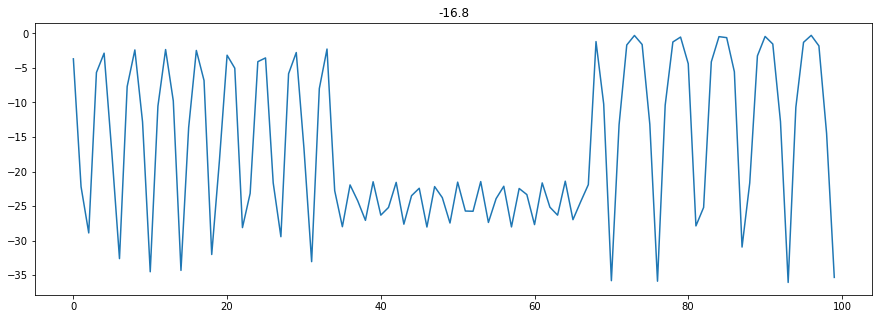

In [12]:
plt.figure(figsize=(15,5))
plt.plot(REWARDS)
plt.title(np.mean(REWARDS).round(1))
plt.show()

Test policy

In [23]:
model.policy(np.array([1,1,0]))

array([-0.00016197])

In [23]:
import gym
env = gym.make('Pendulum-v1', g=9.82)
observation = env.reset()

for step in range(TOTAL_STEPS):
    env.render()
    
    action = model.get_actions(observation)
    observation, reward, done, info = env.step(action)
    
    if done:
        observation = env.reset()
        
env.close()